[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/StatisticalInferenceBasics.ipynb)

# Statistical Inference

We will consider two large umbrellas of problems

- Estimation
- Detection (which in a sense can also be thought of as estimation of categorical parameters)

## Estimation

Measurements are modeled as arising from some statistical distribution. The parameters of the distribution, which are not directly observed, are then estimated from the data. A simple example would be that the heights of a sample of people are modeled as arising from a normal distribution, say $\mathcal{N}(\mu, \sigma^2)$. $\mu$ and $\sigma$ are then the unknown "paramters" of the model. These parameters can then be estimated from data, i.e., measurements of heights. We will extend this simple estimation problem to signals/images etc. (modeled as random processes, random fields, etc.).

More on this later.

## Detection a.k.a Hypothesis Testing a.k.a Classification

Here the problem is to make a decision (usually binary), as to whether the measurements are consistent with a model or not. A more general way of looking at this problem is to ask which among a set of models is the data most consistent with. When two models are in question, the problem is a binary detection/classification problem.

A simple example of detection occurs in newborn hearing screening, where as in Problem Set 2, sounds are played to the baby's ear and a voltage response is measured across a pair of scalp electrodes. Here, the question is -- is there a response (i.e., hearing screening passed), or is there **no** response (i.e., no pass, follow-up needed)?

In [1]:
import numpy as np
import pylab as pl
from scipy import io

dat = io.loadmat('hearingscreening.mat', squeeze_me=True)

In [2]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'clicks', 'fs', 'raw'])

In [3]:
# Filtering
from scipy import signal
p = int(dat['fs']/30)
h = signal.firwin(p, (70, 3000), pass_zero='bandpass', fs=dat['fs'])
x = signal.filtfilt(h, 1, dat['raw'])

In [4]:
# Epoching
tmin, tmax = (-0.01, 0.02)
inds = np.arange(int(tmin * dat['fs']), int(tmax * dat['fs']))
t = (inds / dat['fs']) * 1000  # Milliseconds
Ntrials = dat['clicks'].shape[0]
Ntime = inds.shape[0]
epochs = np.zeros((Ntrials, Ntime))

for k in range(Ntrials):
    epochs[k, :] = x[dat['clicks'][k] + inds]


Text(0, 0.5, 'ABR ($\\mu$V)')

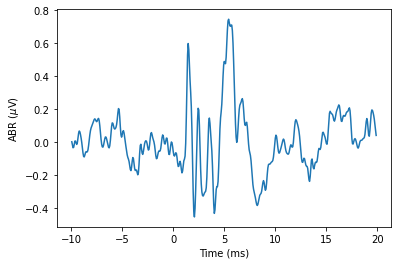

In [5]:
abr = epochs.mean(axis=0)
pl.plot(t, abr)
pl.xlabel('Time (ms)')
pl.ylabel('ABR ($\mu$V)')

## Drawing "null" examples using permutation

Here the null hypothesis, $\mathcal{H}_0$ is that the baby has no hearing, or equivalently the measured response is just background noise. To statistically test this, we need to either construct a model of what the data would look like under $\mathcal{H}_0$, or have a large number of examples of data for which $\mathcal{H}_0$ is known to be true. 

A full model of the signal under $\mathcal{H}_0$ is a random process description. In this scenario, a mean zero gaussian random process with some autocorrelation function $R_{xx}(\tau)$ would be a reasonable model. $R_{xx}(\tau)$ would also need to be estimated from some data for which $\mathcal{H}_0$ is known to be true (e.g., baseline measurements without sound, data from deaf babies, etc.).

Another approach, which is very powerful and can be applied to many problems is that of using permutations of existing data to somehow simulate examples of what you might get when $\mathcal{H}_0$ is in fact true. Here, we are averaging 1000 trials of data (i.e., triggered averaging), and the true response (if there is one) is whatever is the measurement that is phase locked to the sound presentation and thus survives averaging. The noise gets progressively smaller with more and more trials. If we were to flip the polarity of half the trials, the true response, would also flip in those trials -- then when we average the trials together, the response gets "cancelled out" and we up with an example of what we might get under $\mathcal{H}_0$. 

In [6]:
flip = np.concatenate([np.ones(int(Ntrials/2)), np.ones(int(Ntrials/2))*-1])

Here, we flip the polarity of 500 trials, leave 500 intact, and average the resulting 1000 together. The choice of which 500 we flip is arbitrary, and so we could generate **many** examples of noise by randomly choosing different subsets of 500 trials each time. This is illustrate below.

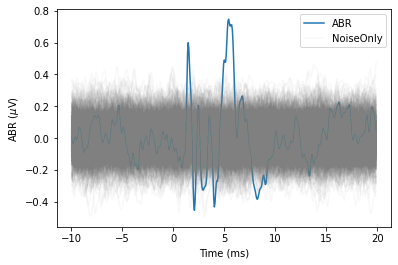

In [7]:
pl.plot(t, abr)

for k in range(1000):
    flip = flip[np.random.permutation(Ntrials)]
    noiseOnly = (epochs * flip[:, None]).mean(axis=0)
    noiseOnly = (epochs * flip[:, None]).mean(axis=0)
    pl.plot(t, noiseOnly, color=[0.5, 0.5, 0.5], alpha=0.05)
pl.xlabel('Time (ms)')
pl.ylabel('ABR ($\mu$V)')
pl.legend(['ABR', 'NoiseOnly'])

As can be seen from the plot, none of the 1000 examples show a peak as high as the peak of the actual ABR. This tells us that the p-value of the ABR peak being as high it is $< 0.001$.